# Loan Default Prediction

In [108]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import tree, ensemble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, 
                             precision_score,
                             precision_recall_curve, 
                             recall_score, 
                             roc_auc_score,
                             auc, 
                             roc_curve,
                             classification_report, 
                             confusion_matrix)
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from optuna.importance import get_param_importances

import optuna
from sklearn.tree import DecisionTreeClassifier
import matplotlib

# Load and explore the data

In [109]:
loan_data = pd.read_csv(os.path.join(os.getcwd(), 'loan_default_dataset' , 'loan_default.csv'))

In [110]:
loan_data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [112]:
loan_data.shape

(255347, 18)

In [113]:
loan_data.info() # DTIRatio = Debt To Income Ratio = Loan Payment / Income

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [114]:
cols = ['NumCreditLines','LoanTerm', 'Education', 'EmploymentType', 'MaritalStatus','LoanPurpose']
for c in cols:
    print(f'Column: {c}')
    print(loan_data[c].unique())

Column: NumCreditLines
[4 1 3 2]
Column: LoanTerm
[36 60 24 48 12]
Column: Education
["Bachelor's" "Master's" 'High School' 'PhD']
Column: EmploymentType
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
Column: MaritalStatus
['Divorced' 'Married' 'Single']
Column: LoanPurpose
['Other' 'Auto' 'Business' 'Home' 'Education']


In [115]:
# Check Null Values

loan_data.isnull().sum() # There are no null values. 

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [116]:
loan_data.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

In [117]:
num_features = ['Age', 'Income', 'LoanAmount', 'CreditScore','InterestRate','DTIRatio']
cat_features = [ 'NumCreditLines','LoanTerm', 'Education', 'EmploymentType', 'MaritalStatus',
                 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

In [118]:
loan_data[num_features].describe()

,Age,Income,LoanAmount,CreditScore,InterestRate,DTIRatio
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,13.492773,0.500212
std,14.990258,38963.013729,70840.706142,158.903867,6.636443,0.230917
min,18.000000,15000.000000,5000.000000,300.000000,2.000000,0.100000
25%,31.000000,48825.500000,66156.000000,437.000000,7.770000,0.300000
50%,43.000000,82466.000000,127556.000000,574.000000,13.460000,0.500000
75%,56.000000,116219.000000,188985.000000,712.000000,19.250000,0.700000
max,69.000000,149999.000000,249999.000000,849.000000,25.000000,0.900000


In [119]:
loan_data['YearsEmploed'] = loan_data['MonthsEmployed'] / 12
loan_data['YearsEmploed'].describe()

count    255347.000000
mean          4.961831
std           2.886948
min           0.000000
25%           2.500000
50%           5.000000
75%           7.500000
max           9.916667
Name: YearsEmploed, dtype: float64

In [120]:
# Number of default through the whole dataset
loan_data['Default'].sum()

np.int64(29653)

In [121]:
# Percentage of defaults through out the fulll dataset.
(loan_data['Default'].sum()/loan_data['Default'].count()).round(4)

np.float64(0.1161)

In [122]:
loan_data['Default'].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

In [123]:
loan_data['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [124]:
# Categorical Variables Distribution

for feature in cat_features[:3]:
    print(loan_data[feature].value_counts(normalize=True))
    print('-'*30)

NumCreditLines
2    0.251148
3    0.249989
4    0.249970
1    0.248893
Name: proportion, dtype: float64
------------------------------
LoanTerm
48    0.200378
60    0.200331
36    0.199967
24    0.199763
12    0.199560
Name: proportion, dtype: float64
------------------------------
Education
Bachelor's     0.252073
High School    0.250259
Master's       0.248842
PhD            0.248826
Name: proportion, dtype: float64
------------------------------


In [125]:
for feature in cat_features[3:7]:
    print(loan_data[feature].value_counts(normalize=True))
    print('-'*30)

EmploymentType
Part-time        0.251270
Unemployed       0.249950
Self-employed    0.249488
Full-time        0.249292
Name: proportion, dtype: float64
------------------------------
MaritalStatus
Married     0.334063
Divorced    0.333010
Single      0.332927
Name: proportion, dtype: float64
------------------------------
HasMortgage
Yes    0.500014
No     0.499986
Name: proportion, dtype: float64
------------------------------
HasDependents
Yes    0.500268
No     0.499732
Name: proportion, dtype: float64
------------------------------


In [126]:
for feature in cat_features[7:]:
    print(loan_data[feature].value_counts(normalize=True))
    print('-'*30)

LoanPurpose
Business     0.200895
Home         0.200848
Education    0.199748
Other        0.199391
Auto         0.199117
Name: proportion, dtype: float64
------------------------------
HasCoSigner
Yes    0.500108
No     0.499892
Name: proportion, dtype: float64
------------------------------


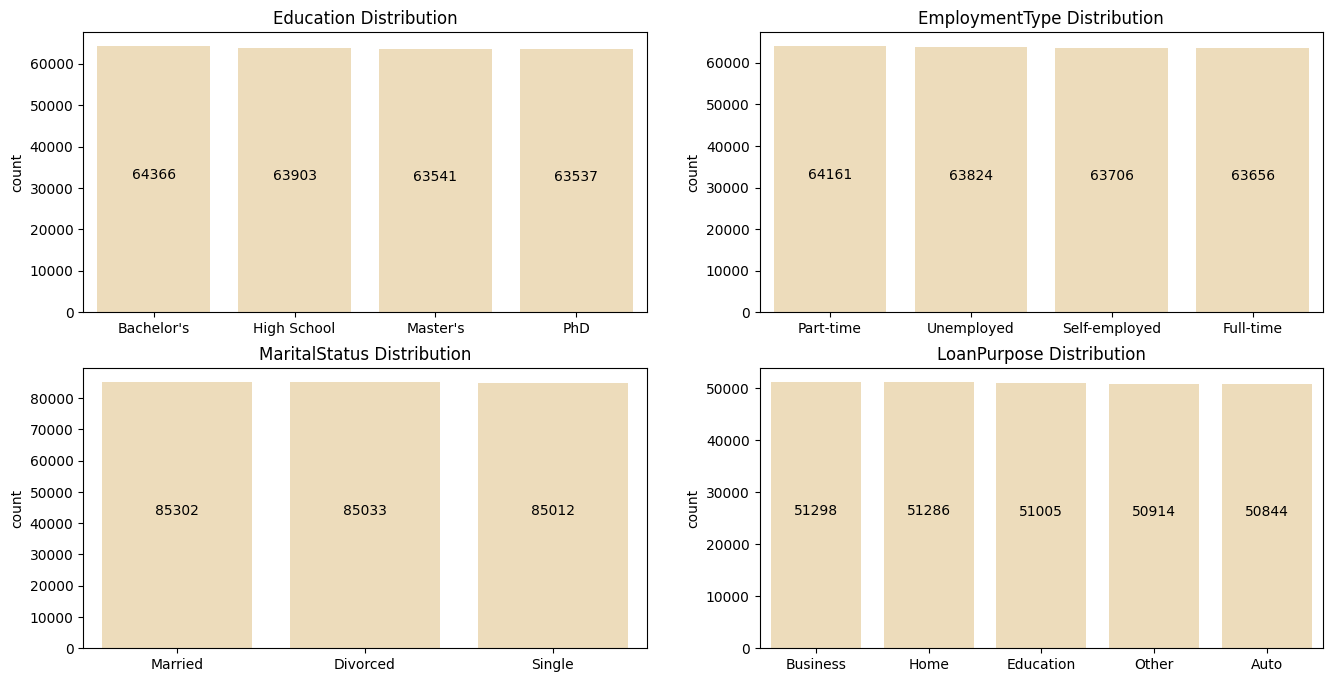

In [127]:
cat_features_dum = [ 'Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']

index = 1
plt.figure(figsize=(16, 8))

for col in cat_features_dum:
    plt.subplot(2, 2 , index)
    ax = sns.countplot(data = loan_data, x=col, order=loan_data[col].value_counts().index, color='wheat')
    ax.set_xlabel('')
    plt.title(f"{col} Distribution")

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='center', padding=3)

    index +=1
plt.show()

In [128]:
# We can see in the above statistics and in the charts that the categorical variables are well distributed.

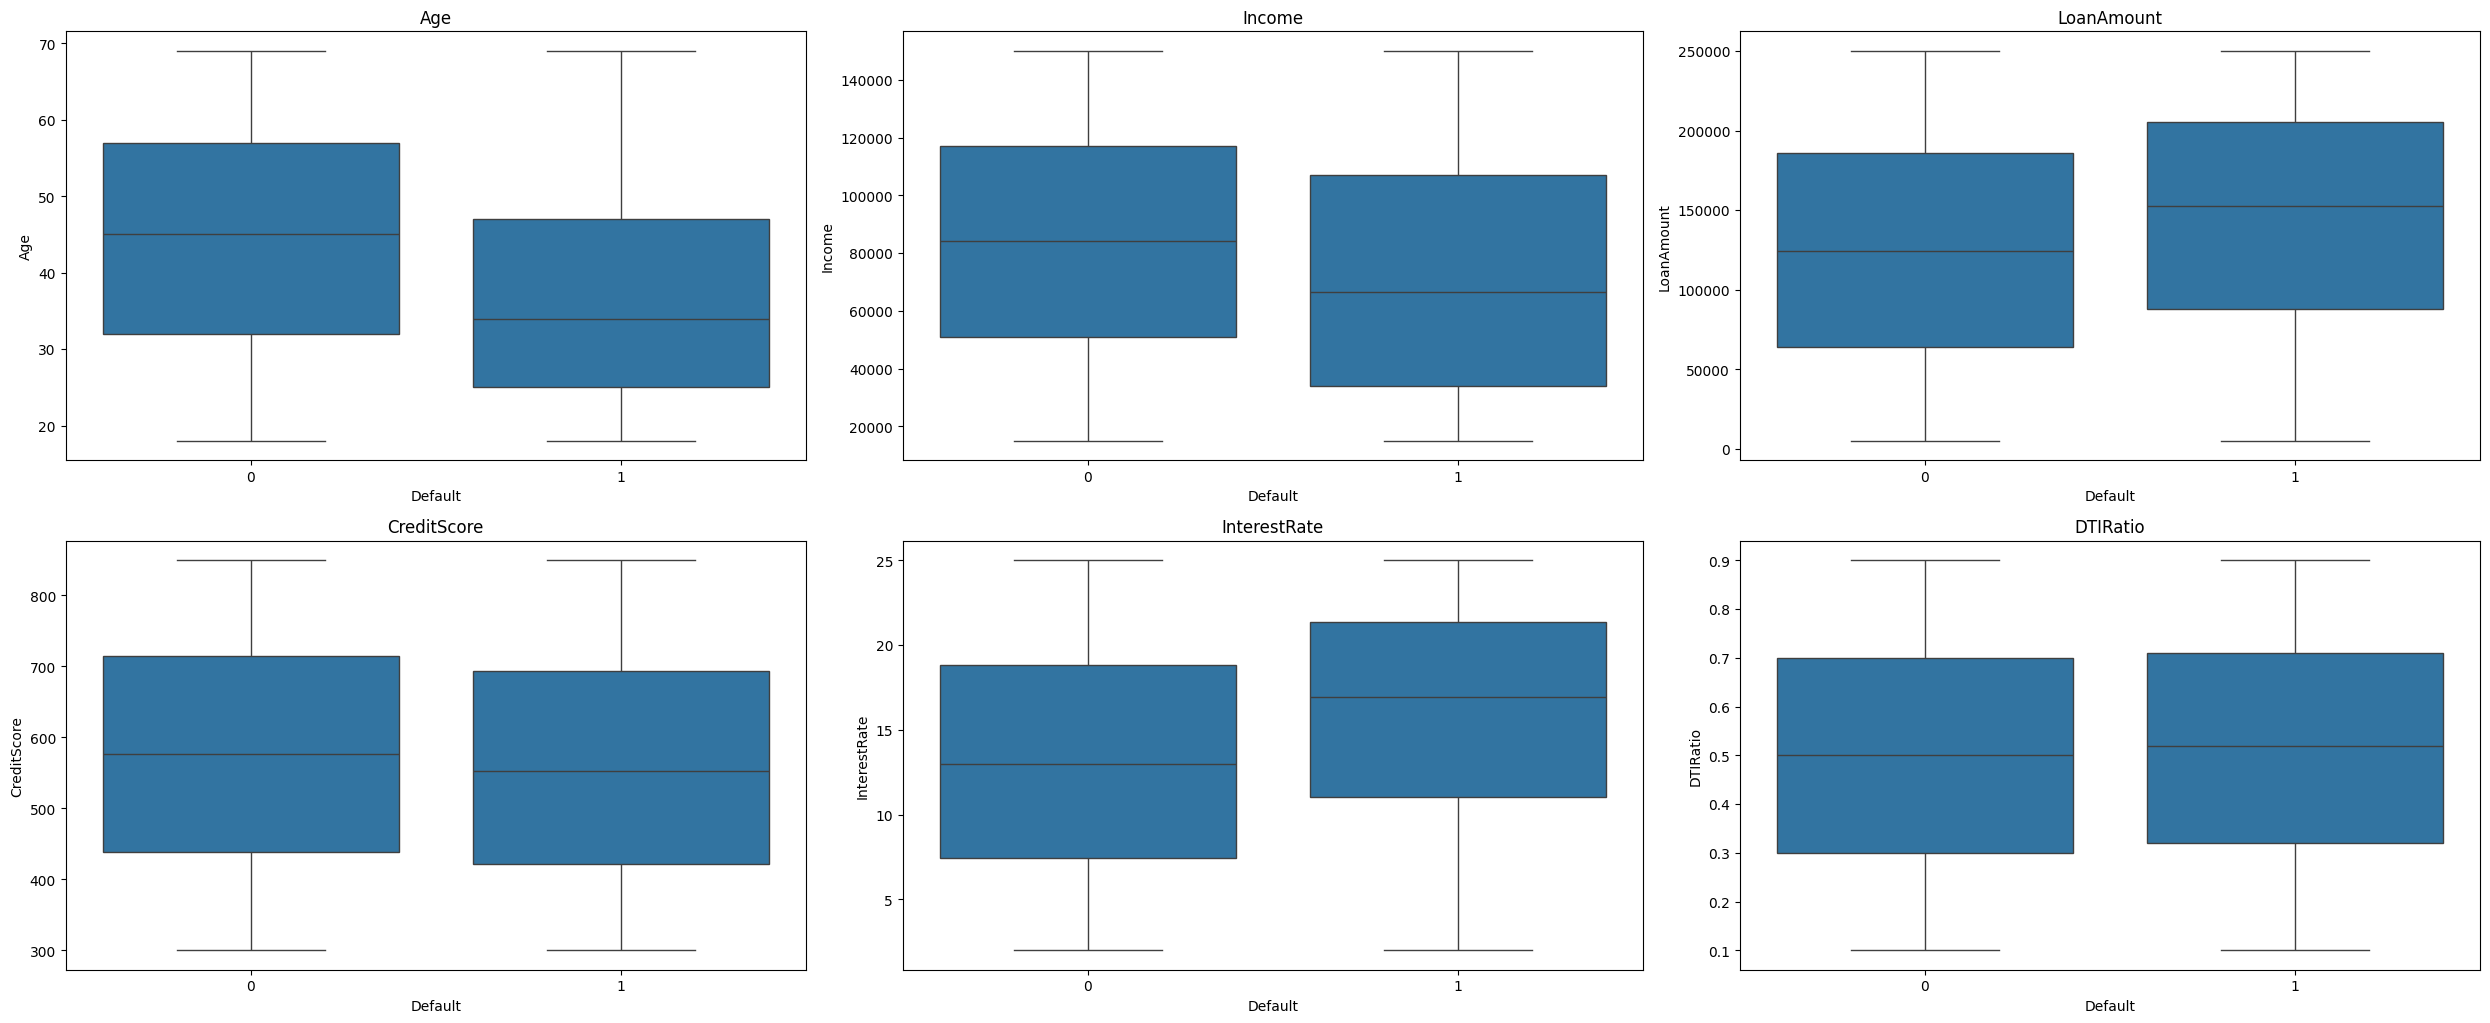

In [129]:
# Identification of outliers in a visual way

index = 1
plt.figure(figsize = (25,15))
for column  in num_features:
    
    plt.subplot(3, 3, index)
    sns.boxplot(x = loan_data['Default'], y = loan_data[column])
    index +=1
    plt.title(f"{column}")
    #plt.xlabel('')

plt.tight_layout()
plt.show()

In [130]:
# The data seems to be quite clean, without presence of Null Values either Outliers. 

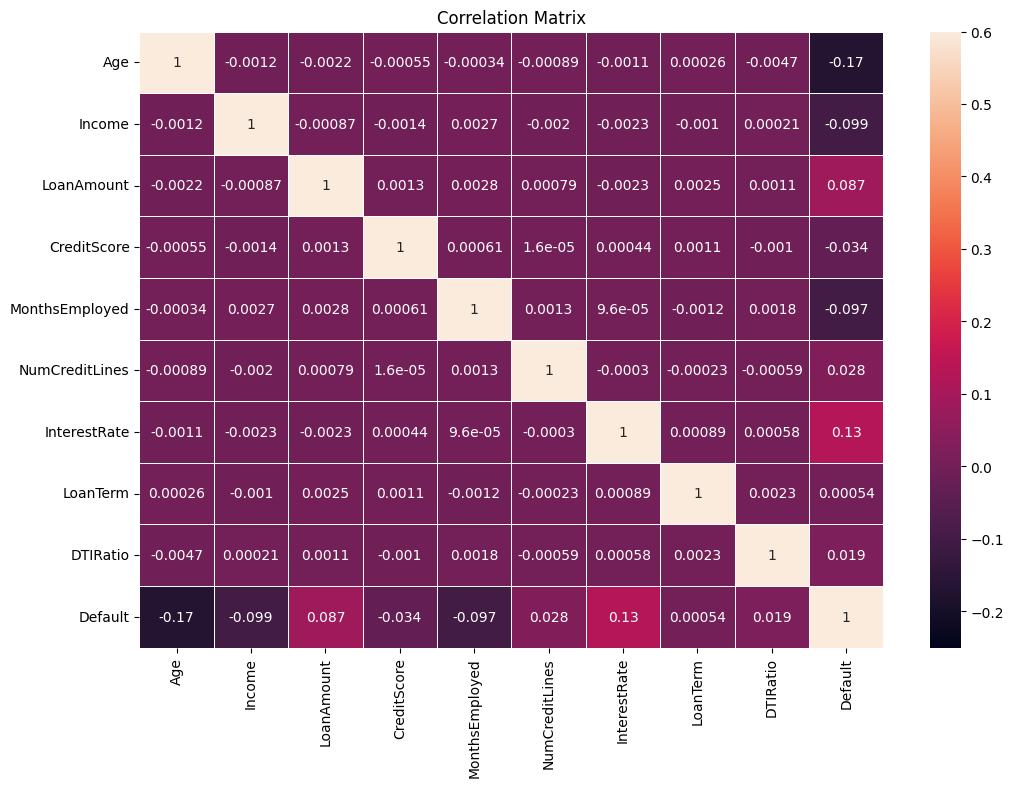

In [131]:
# Features Correlation

plt.figure(figsize = (12,8))
sns.heatmap(loan_data[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                        'NumCreditLines','InterestRate', 'LoanTerm', 'DTIRatio', 'Default']].corr()
            , linewidth = 0.5
            , vmin = -0.25
            , annot=True
            , vmax = 0.6)
plt.title('Correlation Matrix')
plt.show()

In [132]:
# Correlation Matrix outputs: 

# It can be appreciated in the heatmap that there is a positive correlation between the Interest Rate and Loan Amount with Default. 
# As well, a less strong positive correlation between the Number of Credit Lines and Defaults. 
# On the other hand, we can appreciate an negative correlation between Age and Income with Defaults. Credit Score has also a negative correlation. 



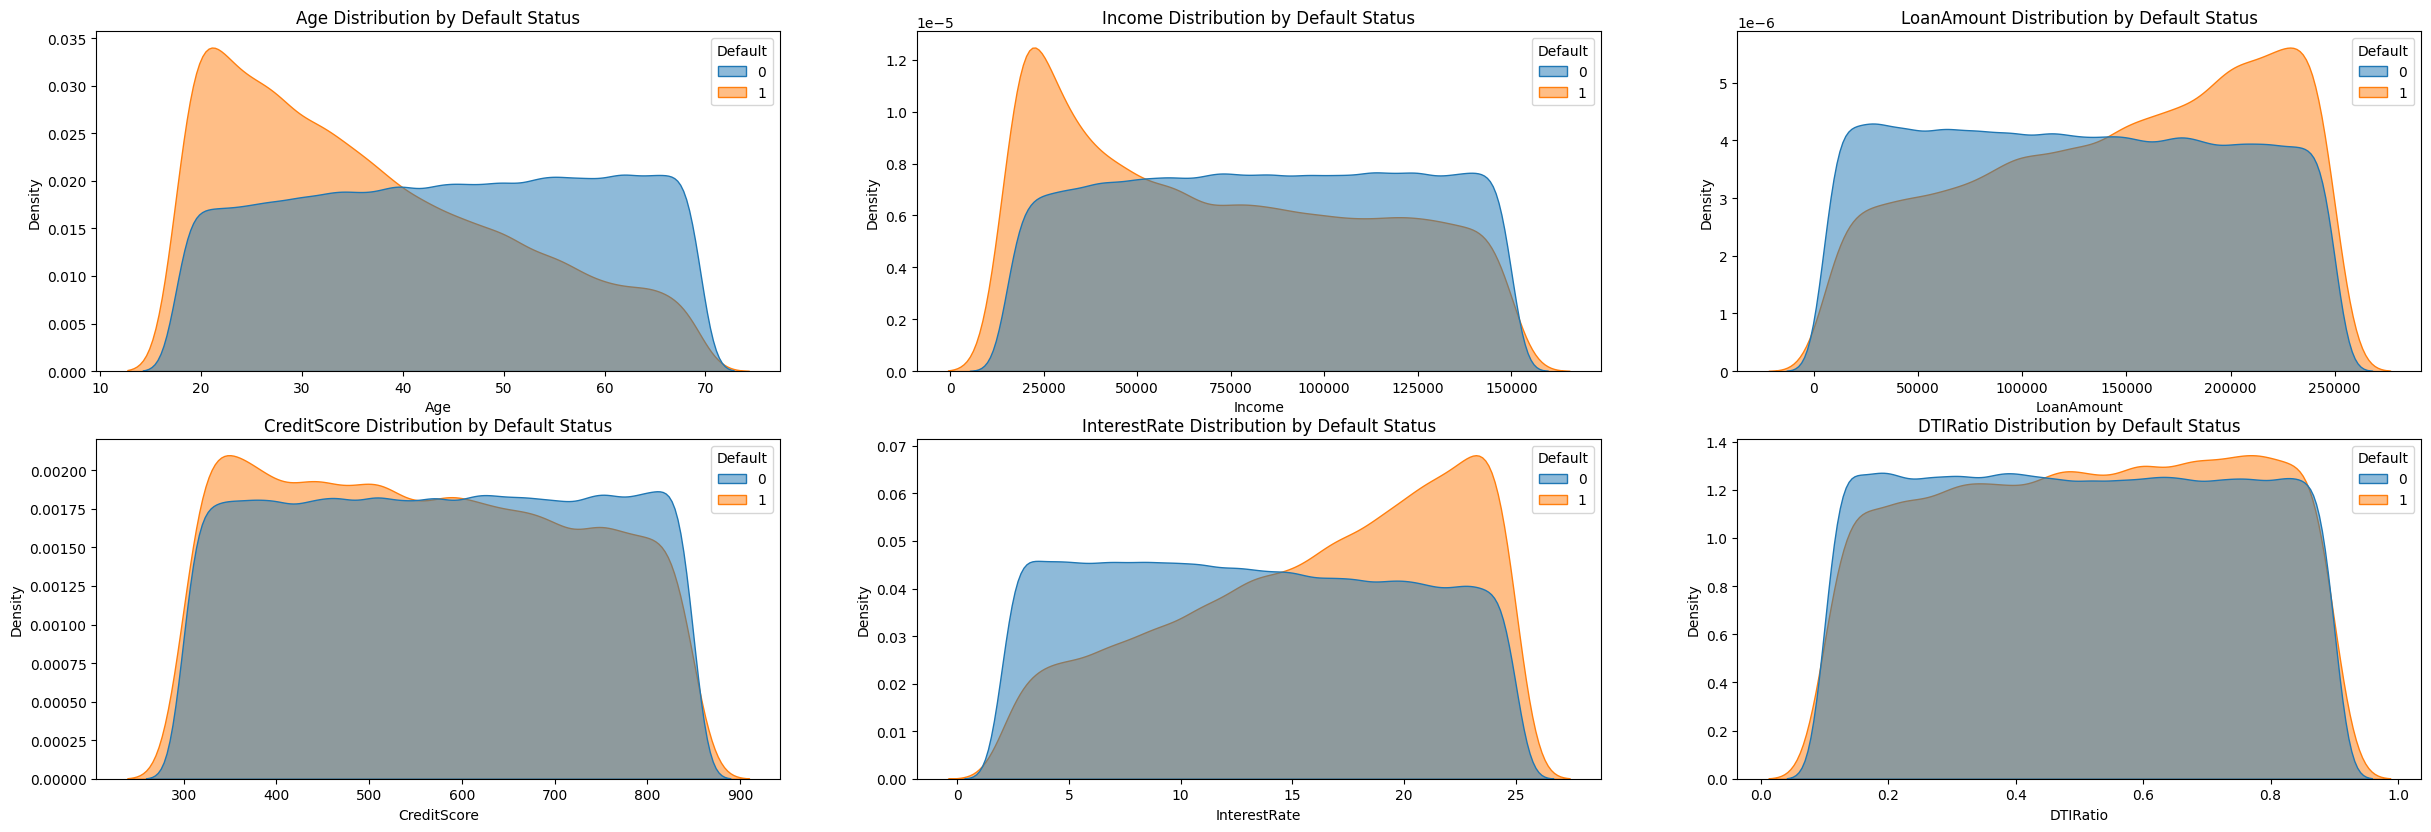

In [133]:
# Defaults distribution per Age, Income, Loan AMount, CrediScore, InterestRates, DTIRatio.

plt.figure(figsize = (30,15))
index = 1
for col in num_features:
    plt.subplot(3, 3, index)
    sns.kdeplot(data=loan_data, x=col, hue='Default', fill=True, common_norm=False, alpha=0.5)
    plt.title(f"{col} Distribution by Default Status")
    index +=1


plt.show()

# Machine Learning Preparation

In [170]:
# New ratios
loan_data_ml = loan_data.copy()
loan_data_ml.rename(columns={'DTIRatio': 'DebtToIncome'}, inplace=True) # DTIRatio = Debt To Income Ratio = Loan Payment / Income

loan_data_ml['LoanToIncome'] = loan_data_ml['LoanAmount'] / loan_data_ml['Income']
loan_data_ml['MonthlyInstallment'] = loan_data['LoanAmount'] / loan_data_ml['LoanTerm']

In [171]:
# Binary columns into boolean

binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
loan_data_ml[binary_cols] = loan_data_ml[binary_cols].replace({'Yes': 1, 'No': 0})

C:\Users\VALERIOA\AppData\Local\Temp\3\ipykernel_11260\1513331384.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_data_ml[binary_cols] = loan_data_ml[binary_cols].replace({'Yes': 1, 'No': 0})


In [172]:
loan_data_ml.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DebtToIncome,...,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,YearsEmploed,LoanToIncome,MonthlyInstallment
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,Full-time,Divorced,1,1,Other,1,0,6.666667,0.588262,1405.194444
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,Full-time,Married,0,0,Other,1,0,1.250000,2.467481,2074.000000
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,Unemployed,Divorced,1,1,Auto,0,1,2.166667,1.534154,5382.833333
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,Full-time,Married,0,0,Business,0,0,0.000000,1.412638,1866.625000
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,Unemployed,Divorced,0,1,Auto,0,0,0.666667,0.447179,190.395833


In [173]:

# Translate the categorical predictors into numerical predictors
loan_data_ml = pd.get_dummies(loan_data_ml, columns=['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'], drop_first=True, dtype=int) #1/0

# Reduce the sample
# loan_data_reduced = loan_data_ml#.sample(n=10000, random_state=42).copy() #The reduction of the sample is only for feature selection

loan_data_ml = loan_data_ml.copy()
# Separate features and target variable
X = loan_data_ml.drop(columns=['LoanID','Default'], axis = 1)
y = loan_data_ml['Default'] # Only the target variable


In [174]:
# Split the full set of data into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True , test_size=0.2, random_state=42)

# Scale the data - For feature selection and Logistic Regression
scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Shapes
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (204277, 27)
Testing set: (51070, 27)


Feature Selection

In [175]:
# Print the distribution of target classes in train and test sets

print("\nDistribution of classes y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of classes y_test:")
print(y_test.value_counts(normalize=True))


Distribution of classes y_train:
Default
0    0.883722
1    0.116278
Name: proportion, dtype: float64

Distribution of classes y_test:
Default
0    0.884472
1    0.115528
Name: proportion, dtype: float64


In [176]:
# The results show that there are imbalanced classes. This can cause the model to:
# Be biased toward the majority class (No Default)
# Fail to detect important rare events 
# Show misleading metrics like high accuracy, even if it's not learning anything useful

In [177]:
# Fit the Random Forest Clssifier Model for feature selection
rf_clf = ensemble.RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf.fit(X_train_scaled, y_train)

feature_imp = rf_clf.feature_importances_

In [178]:
def plot_impurity_metric_features(feature_imp, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(y_ticks, feature_imp[sorted_idx], color='grey')
    plt.xlabel('Importance', fontsize=10)
    plt.ylabel('Feature', fontsize=10)
    
    ax.tick_params(axis='y', labelsize=9) 
    ax.set_yticks(y_ticks)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(xmin, xmax, 0.01))
    ax.set_yticklabels(feature_names[sorted_idx])
    plt.grid()
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()

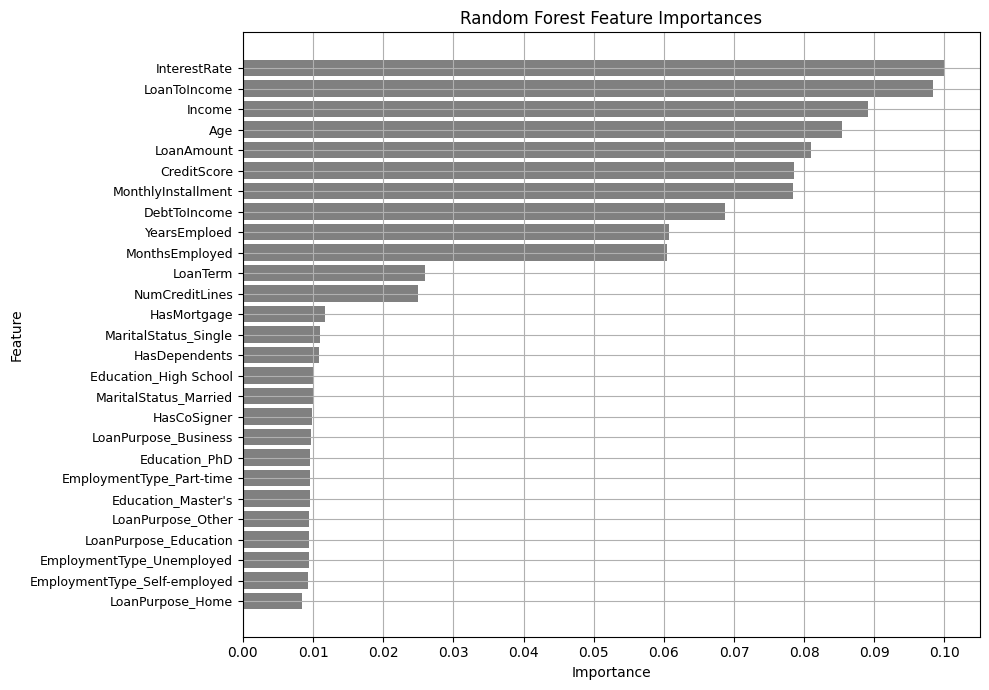

In [179]:
sorted_idx = feature_imp.argsort()
feature_names = X.columns

plot_impurity_metric_features(feature_imp, sorted_idx, feature_names)

In [169]:
# # permutation method on both training and test

# result = permutation_importance(estimator=rf_clf, X=X_train_scaled, y=y_train , n_repeats=3, n_jobs=-1, random_state=42)
# sorted_idx = result.importances_mean.argsort()

# def plot_perm_importance(result, sorted_idx, feature_names):

#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
#     ax.set_title("Permutation Importances (train set)")
#     fig.tight_layout()
#     plt.show()

# plot_perm_importance(result, sorted_idx, feature_names)


In [180]:
# After the above analysis, since the data looks unbalanced, the conclusion is that we should focus on the relevant features and then resample the data based on that.

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_imp})

# Select features based on defined importance
selected_features = importance_df[importance_df['Importance'] > 0.02]['Feature']

# Filter selected features in train and test datasets
X_train_subset = X_train[selected_features]
X_test_subset = X_test[selected_features]

X_train_subset.shape, X_test_subset.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204277, 12), (51070, 12), (204277, 27), (51070, 27), (204277,), (51070,))

In [181]:
# Apply Synthetic Minority Over-sampling Technique (SMOTE) to balance the classes on the training set only!

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_subset, y_train)

In [182]:
# Shapes after SMOTE
print("X_train_resampled_SMOTE shape:", X_train_resampled.shape)
print("y_train_resampled_SMOTE shape:", y_train_resampled.shape)
print("X_test_subset_features shape:", X_test_subset.shape)
print("y_test_original shape:", y_test.shape)

print(y_train_resampled.value_counts(normalize=True)) #This is to see how's the proportional distribution

X_train_resampled_SMOTE shape: (361048, 12)
y_train_resampled_SMOTE shape: (361048,)
X_test_subset_features shape: (51070, 12)
y_test_original shape: (51070,)
Default
0    0.5
1    0.5
Name: proportion, dtype: float64


# Decision Tree

Decission Tree Parameters tunning using Bayesian Optimisation (Optuna) 

Optuna:	Most flexible, good for any framework, nice visualization tools
skopt (BayesSearchCV):	Easy to use for sklearn models, similar to GridSearchCV

In [183]:
# Shapes
print("Train set:", X_train.shape)
print("Test set:", X_test.shape)
print('-------------------')
print("Testg subset:", X_train_subset.shape)
print("Test subset:", X_test_subset.shape)

print(X_train_resampled.shape) #SMOTE
print(y_train_resampled.shape) # SMOTE



Train set: (204277, 27)
Test set: (51070, 27)
-------------------
Testg subset: (204277, 12)
Test subset: (51070, 12)
(361048, 12)
(361048,)


In [238]:

# Define the Optuna objective function
def objective_dt(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create model
    dt_clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Use cross-validation
    score = cross_val_score(dt_clf, X_train_resampled, y_train_resampled, cv=3, scoring = 'recall').mean()
    return score  # Optuna will try to maximize this. 

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=30)

# Print results
print("Best hyperparameters:", study.best_params)

# Train final model with best parameters
dt_best_model = DecisionTreeClassifier(**study.best_params, random_state=42, class_weight='balanced')
dt_best_model.fit(X_train_resampled, y_train_resampled) # Using SMOTE variables

dt_y_pred = dt_best_model.predict(X_test_subset)

print("Test accuracy:", accuracy_score(y_test, dt_y_pred))
print('Recall test:', recall_score(y_test, dt_y_pred))


[I 2025-04-27 13:34:22,565] A new study created in memory with name: no-name-6a3a0ec1-1c03-44d5-a1bb-4387a17d0a58
[I 2025-04-27 13:34:29,816] Trial 0 finished with value: 0.7413421517059513 and parameters: {'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7413421517059513.
[I 2025-04-27 13:34:39,438] Trial 1 finished with value: 0.7649678737367216 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7649678737367216.
[I 2025-04-27 13:34:42,437] Trial 2 finished with value: 0.6911935874354714 and parameters: {'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7649678737367216.
[I 2025-04-27 13:34:47,457] Trial 3 finished with value: 0.7409764361190335 and parameters: {'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.7649678737367216.
[I 2025-04-27 13:34:57,270] Trial 4 finished with value: 0.7

Best hyperparameters: {'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 2}
Test accuracy: 0.4380458194634815
Recall test: 0.8108474576271186


In [239]:
# Define funtions to plot the results of the hyperparameters tunning 

def plot_optimization_history_matplotlib(study):
    values = [t.value for t in study.trials if t.value is not None]
    plt.figure(figsize=(8, 5))
    plt.plot(values, marker='o')
    plt.xlabel("Trial")
    plt.ylabel("Objective Value")
    plt.title("Optimization History")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_param_importances_matplotlib(study):
    importances = get_param_importances(study)
    
    plt.figure(figsize=(8, 5))
    plt.barh(list(importances.keys()), list(importances.values()))
    plt.xlabel("Importance")
    plt.title("Hyperparameter Importances")
    plt.tight_layout()
    plt.show()

def plot_param_vs_objective(study, param_name):
    trials = [t for t in study.trials if t.params.get(param_name) is not None]
    x = [t.params[param_name] for t in trials]
    y = [t.value for t in trials]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)
    plt.xlabel(param_name)
    plt.ylabel("Objective Value")
    plt.title(f"{param_name} vs Objective Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

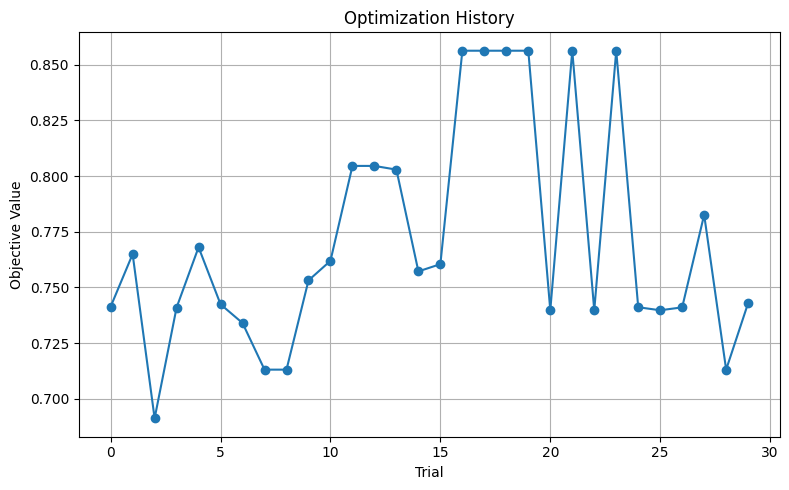

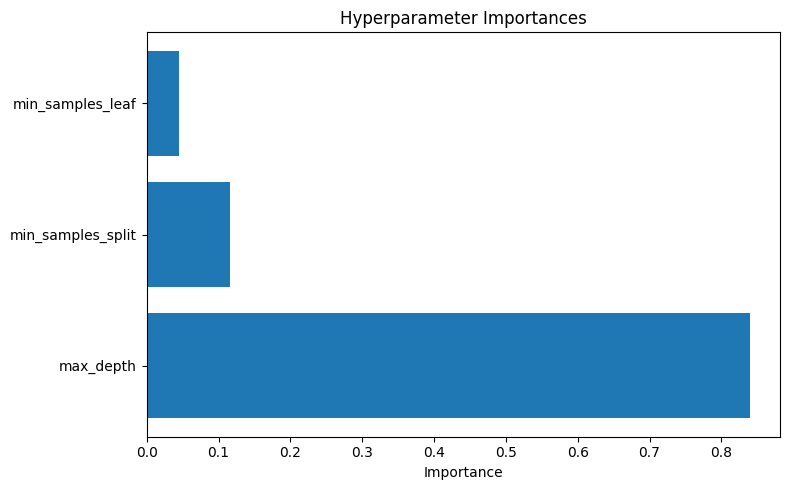

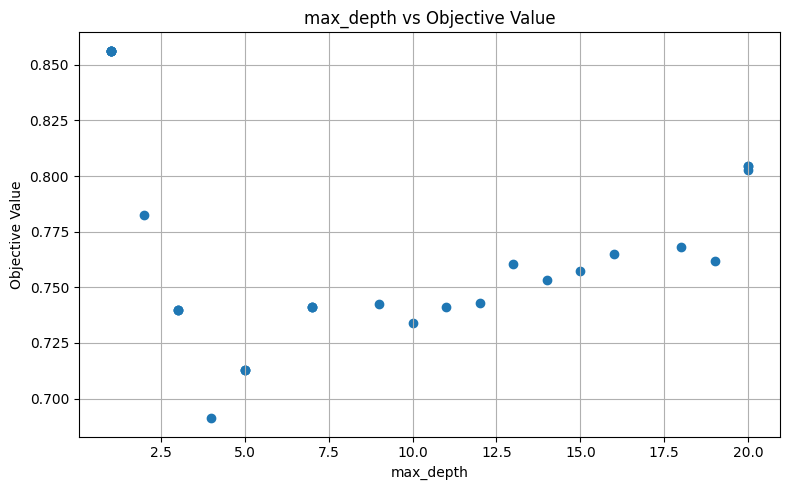

In [240]:
plot_optimization_history_matplotlib(study)
plot_param_importances_matplotlib(study)
plot_param_vs_objective(study, 'max_depth')

Decision Tree Classifier Evaluation

Accuracy: 0.438
Precision: 0.1478
Recall: 0.8108
ROC AUC: 0.6001

------------------------------
Classification Report:
,               precision    recall  f1-score   support

           0       0.94      0.39      0.55     45170
           1       0.15      0.81      0.25      5900

    accuracy                           0.44     51070
   macro avg       0.54      0.60      0.40     51070
weighted avg       0.85      0.44      0.52     51070



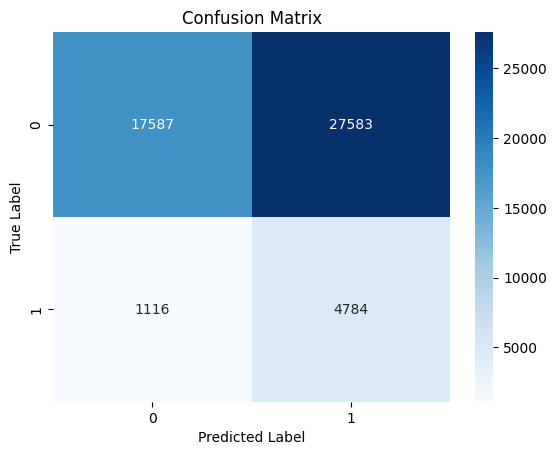

In [241]:
# Evaluate model performance

dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
dt_cm = confusion_matrix(y_test, dt_y_pred)

# See Decision Tree Model results

print("Decision Tree Classifier Evaluation\n")

print("Accuracy:", round(dt_accuracy, 4))
print("Precision:", round(dt_precision, 4))
print("Recall:", round(dt_recall, 4))
print("ROC AUC:", round(dt_roc_auc, 4))
print(f'\n{"-"*30}\nClassification Report:\n, {classification_report(y_test, dt_y_pred)}')

# Confusion matrix heatmap
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Test idea: 

- I tried to maximize the recall since it was more important to identify the defaults, but  I lost a lot of accuracy, therefore, I kept the original idea.  
- Additionally, I tried Decission Tree Parameters tunning using GridSearchCV - Smaller Sample of the data. To use the grid search I needed to reduce the sample number.Since the results were not better than with optuna tunning. I used this latest option. 


End of test

As an experiment, we can see that the if we use the data training as it is, the metrics such as recall show the values are worse

# Random Forest Classification

In [242]:
# Define the Optuna objective function
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])

    # Create model
    clf_rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1  # parallelize - uses all CPU cores
        )

    # Use cross-validation
    score = cross_val_score(clf_rf, X_train_resampled, y_train_resampled, cv=3, scoring = 'recall').mean()
    return score  # to maximize recall

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=20)

# Print results
print("Best hyperparameters:", study.best_params)

# Train final model with best parameters
rf_best_model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
rf_best_model.fit(X_train_resampled, y_train_resampled)

rf_y_pred = rf_best_model.predict(X_test_subset)

print("Test accuracy:", accuracy_score(y_test, rf_y_pred))
print('Recall test:', recall_score(y_test, rf_y_pred))

[I 2025-04-27 13:37:58,865] A new study created in memory with name: no-name-a8c07a8a-72bf-4620-8ee1-ad5c50682f6f
[I 2025-04-27 13:38:08,519] Trial 0 finished with value: 0.7403006245650712 and parameters: {'n_estimators': 83, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.7403006245650712.
[I 2025-04-27 13:39:32,473] Trial 1 finished with value: 0.7612176836921346 and parameters: {'n_estimators': 88, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None, 'class_weight': None}. Best is trial 1 with value: 0.7612176836921346.
[I 2025-04-27 13:39:42,411] Trial 2 finished with value: 0.7479783068468105 and parameters: {'n_estimators': 57, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 1 with value: 0.7612176836921346.
[I 2025-04-27 13:40:47,302] Trial 3 finished with value: 0.7564648347240

Best hyperparameters: {'n_estimators': 92, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}
Test accuracy: 0.7735265322106912
Recall test: 0.3864406779661017


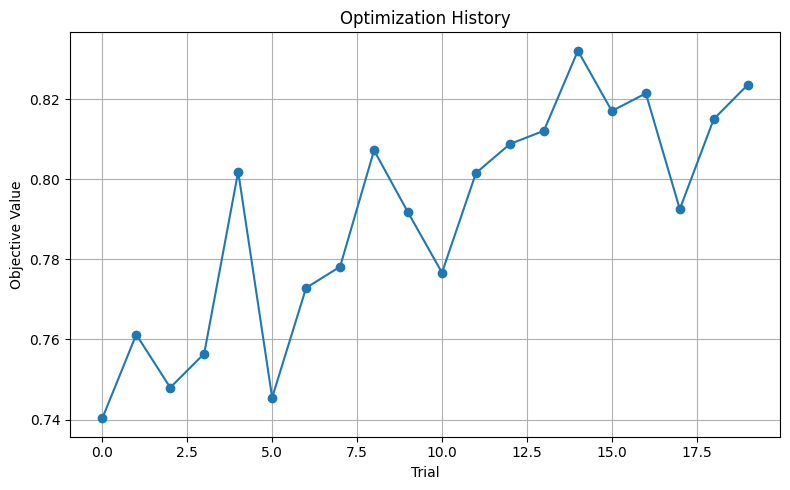

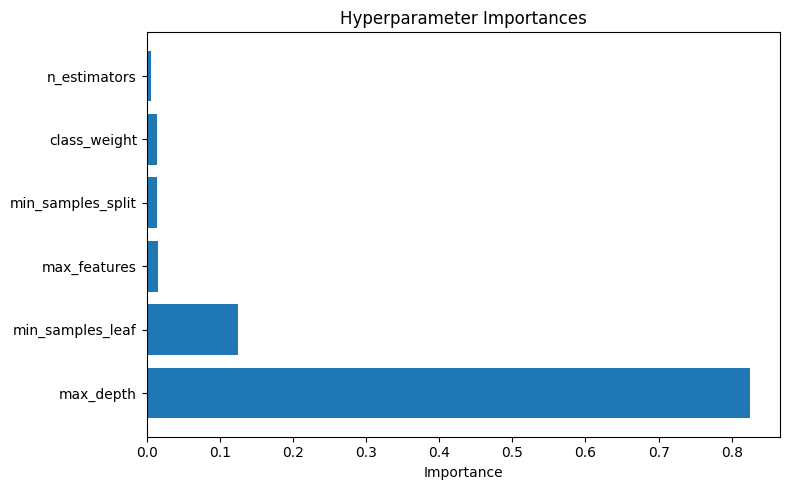

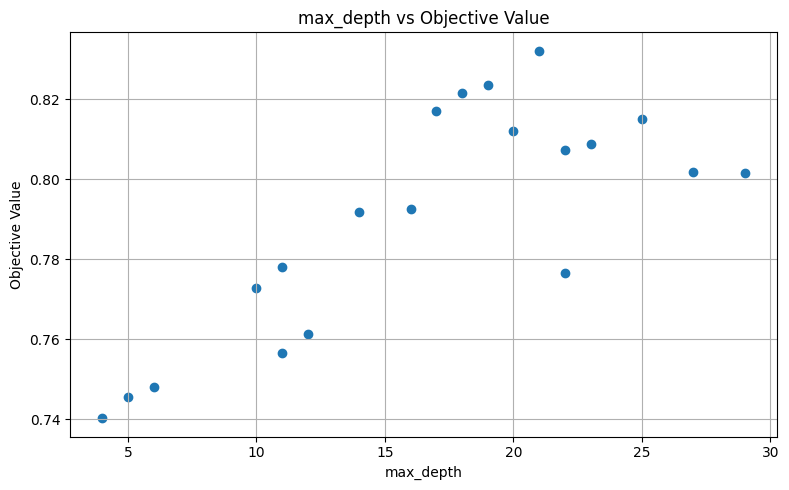

In [243]:
plot_optimization_history_matplotlib(study)
plot_param_importances_matplotlib(study)
plot_param_vs_objective(study, 'max_depth')

Random Forest Classifier Evaluation

Accuracy: 0.7735
Precision: 0.223
Recall: 0.3864
ROC AUC: 0.6053

------------------------------
Classification Report:
,               precision    recall  f1-score   support

           0       0.91      0.82      0.87     45170
           1       0.22      0.39      0.28      5900

    accuracy                           0.77     51070
   macro avg       0.57      0.61      0.57     51070
weighted avg       0.83      0.77      0.80     51070



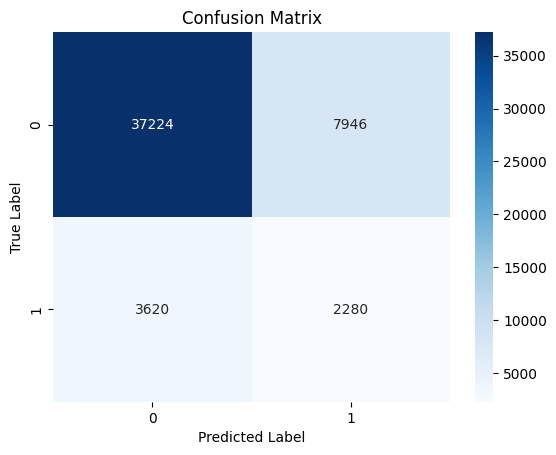

In [244]:
# Evaluate model performance Random Forest

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_cm = confusion_matrix(y_test, rf_y_pred)

print("Random Forest Classifier Evaluation\n")

print("Accuracy:", round(rf_accuracy, 4))
print("Precision:", round(rf_precision, 4))
print("Recall:", round(rf_recall, 4))
print("ROC AUC:", round(rf_roc_auc, 4))
print(f'\n{"-"*30}\nClassification Report:\n, {classification_report(y_test, rf_y_pred)}')

# Confusion matrix heatmap
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# k-Nearest Neighbors (KNN) Classifier

In [245]:

# Define the Optuna objective function
def objective_knn(trial):
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)
    weights = trial.suggest_categorical('weights',['uniform' , 'distance'])
    metric = trial.suggest_categorical('metric',['euclidean', 'manhattan'])

    # Create model
    knn_clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
    )

    # Use cross-validation
    score = cross_val_score(knn_clf, X_train_resampled, y_train_resampled, cv=3, scoring = 'recall').mean()
    
    # knn_clf.fit(X_train_resampled, y_train_resampled)
    # knn_y_pred = knn_clf.predict(X_test_subset)
    # recall = recall_score(y_test, knn_y_pred)
    # return recall
    return score  # Optuna will try to maximize this

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=20)

# Print results
print("Best hyperparameters:", study.best_params)

# Train final model with best parameters
knn_best_model = KNeighborsClassifier(**study.best_params)
knn_best_model.fit(X_train_resampled, y_train_resampled)

knn_y_pred = knn_best_model.predict(X_test_subset)

print("Test accuracy:", accuracy_score(y_test, knn_y_pred))
print('Recall test:', recall_score(y_test, knn_y_pred))


[I 2025-04-27 13:55:56,957] A new study created in memory with name: no-name-823b6cf8-c91c-4203-8ad2-9eba2b30e641
[I 2025-04-27 13:56:04,926] Trial 0 finished with value: 0.9334880912933161 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.9334880912933161.
[I 2025-04-27 13:56:12,613] Trial 1 finished with value: 0.9343300848165349 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9343300848165349.
[I 2025-04-27 13:56:18,739] Trial 2 finished with value: 0.9118787532036704 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.9343300848165349.
[I 2025-04-27 13:56:34,931] Trial 3 finished with value: 0.8418271611873184 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9343300848165349.
[I 2025-04-27 13:56:43,327] Trial 4 finished with value: 0.9324

Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}
Test accuracy: 0.6532406500881144
Recall test: 0.3688135593220339


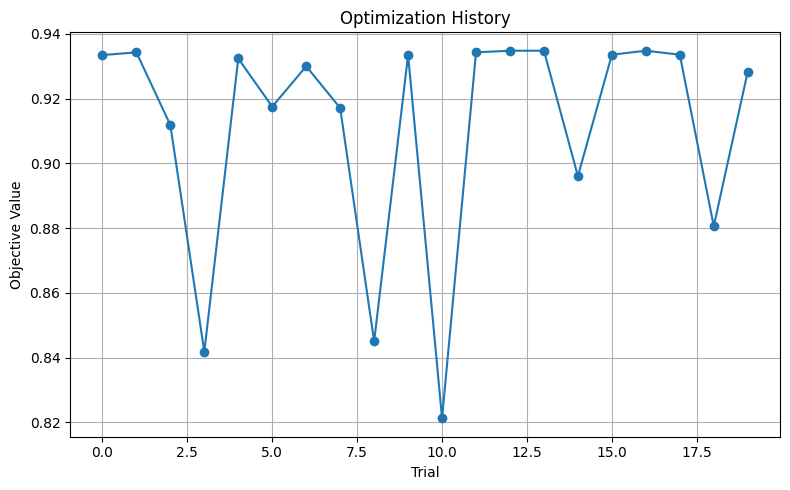

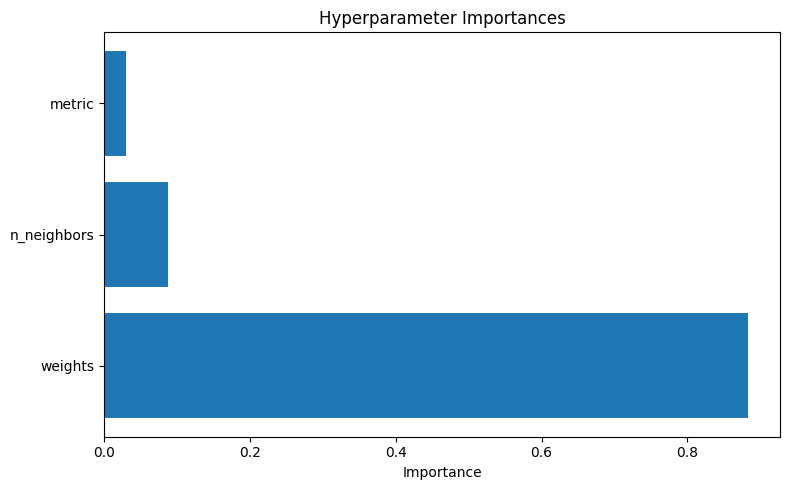

In [246]:
plot_optimization_history_matplotlib(study)
plot_param_importances_matplotlib(study)


KNN Classifier Evaluation

Accuracy: 0.6532
Precision: 0.1346
Recall: 0.3688
ROC AUC: 0.5296

------------------------------
Classification Report:
,               precision    recall  f1-score   support

           0       0.89      0.69      0.78     45170
           1       0.13      0.37      0.20      5900

    accuracy                           0.65     51070
   macro avg       0.51      0.53      0.49     51070
weighted avg       0.81      0.65      0.71     51070



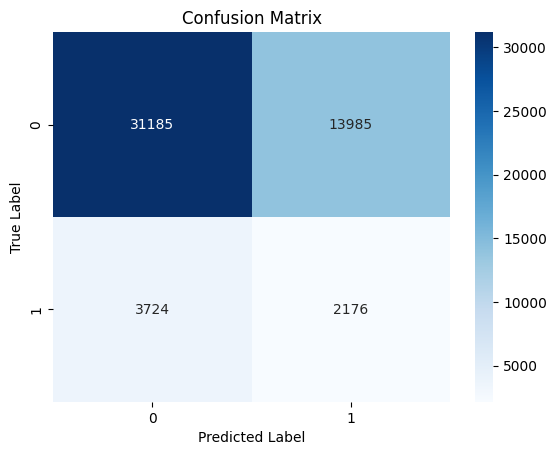

In [247]:
# Evaluate model performance KNN

knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred)
knn_cm = confusion_matrix(y_test, knn_y_pred)


print("KNN Classifier Evaluation\n")

print("Accuracy:", round(knn_accuracy, 4))
print("Precision:", round(knn_precision, 4))
print("Recall:", round(knn_recall, 4))
print("ROC AUC:", round(knn_roc_auc, 4))
print(f'\n{"-"*30}\nClassification Report:\n, {classification_report(y_test, knn_y_pred)}')

# Confusion matrix heatmap
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Logistic Regression

In [248]:
# For logistic regression tunning the parameters was quite slow and considering that it doesn't ahve so many, I didn't tune it. 

In [249]:
# Train final model with best parameters
log_clf = LogisticRegression( random_state=42, class_weight='balanced')
log_clf.fit(X_train_resampled, y_train_resampled)

log_y_pred = log_clf.predict(X_test_subset)

print("Test accuracy:", accuracy_score(y_test, log_y_pred))
print('Recall test:', recall_score(y_test, log_y_pred))


Test accuracy: 0.669453691012336
Recall test: 0.6277966101694915


c:\Programs\Python\Envs\py311ml\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classifier Evaluation

Accuracy: 0.6695
Precision: 0.2014
Recall: 0.6278
ROC AUC: 0.6513

------------------------------
Classification Report:
,               precision    recall  f1-score   support

           0       0.93      0.67      0.78     45170
           1       0.20      0.63      0.30      5900

    accuracy                           0.67     51070
   macro avg       0.57      0.65      0.54     51070
weighted avg       0.85      0.67      0.73     51070



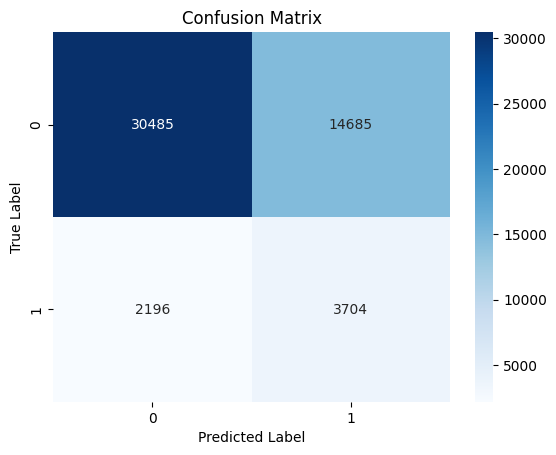

In [250]:
# Evaluate model performance Logistic Regression

log_accuracy = accuracy_score(y_test, log_y_pred)
log_precision = precision_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_roc_auc = roc_auc_score(y_test, log_y_pred)
log_cm = confusion_matrix(y_test, log_y_pred)


print("Logistic Regression Classifier Evaluation\n")

print("Accuracy:", round(log_accuracy, 4))
print("Precision:", round(log_precision, 4))
print("Recall:", round(log_recall, 4))
print("ROC AUC:", round(log_roc_auc, 4))
print(f'\n{"-"*30}\nClassification Report:\n, {classification_report(y_test, log_y_pred)}')

# Confusion matrix heatmap
sns.heatmap(log_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# XGBoost Classifier

In [251]:

# Define the Optuna objective function
def objective_xgb(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 2, 20)
    gamma = trial.suggest_float('gamma', 0.1, 0.3)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    # Create model
    xgb_clf = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma = gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    # Use cross-validation
    score = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, cv=3, scoring = 'recall').mean()
    #score = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring='recall').mean()
    return score  # Optuna will try to maximize this

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=20)

# Print results
print("Best hyperparameters:", study.best_params)

# Train final model with best parameters
xgb_best_model = XGBClassifier(**study.best_params, random_state=42, objective='binary:logistic')
xgb_best_model.fit(X_train_resampled, y_train_resampled)

xgb_y_pred = xgb_best_model.predict(X_test_subset)

print("Test accuracy:", accuracy_score(y_test, xgb_y_pred))
print('Recall test:', recall_score(y_test, xgb_y_pred))


[I 2025-04-27 13:59:11,489] A new study created in memory with name: no-name-54a314a2-09fe-4140-b424-a98b0848dfa0
[I 2025-04-27 13:59:15,652] Trial 0 finished with value: 0.7934295177691936 and parameters: {'learning_rate': 0.04233566968331675, 'max_depth': 10, 'min_child_weight': 13, 'gamma': 0.2582520169356851, 'reg_alpha': 0.5166241223181698, 'reg_lambda': 0.17627077480893827}. Best is trial 0 with value: 0.7934295177691936.
[I 2025-04-27 13:59:18,457] Trial 1 finished with value: 0.7967033562323972 and parameters: {'learning_rate': 0.06404165132540077, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.27171883389815255, 'reg_alpha': 0.05518045410100736, 'reg_lambda': 0.5859348985122163}. Best is trial 1 with value: 0.7967033562323972.
[I 2025-04-27 13:59:21,418] Trial 2 finished with value: 0.7960386089314814 and parameters: {'learning_rate': 0.06564837149930935, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.133802049684467, 'reg_alpha': 0.31947087713451316, 'reg_lambda': 0.3

Best hyperparameters: {'learning_rate': 0.08959300316268834, 'max_depth': 10, 'min_child_weight': 12, 'gamma': 0.25408528351766524, 'reg_alpha': 0.8227309767052501, 'reg_lambda': 0.288121319700631}
Test accuracy: 0.8123751713334638
Recall test: 0.3305084745762712


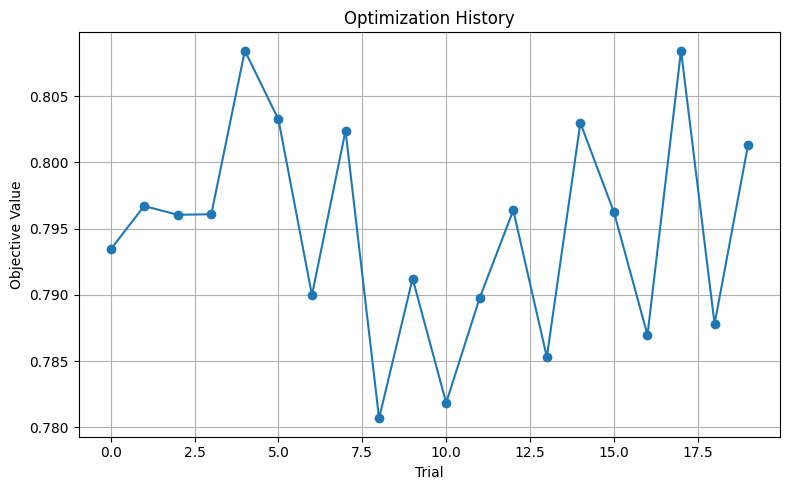

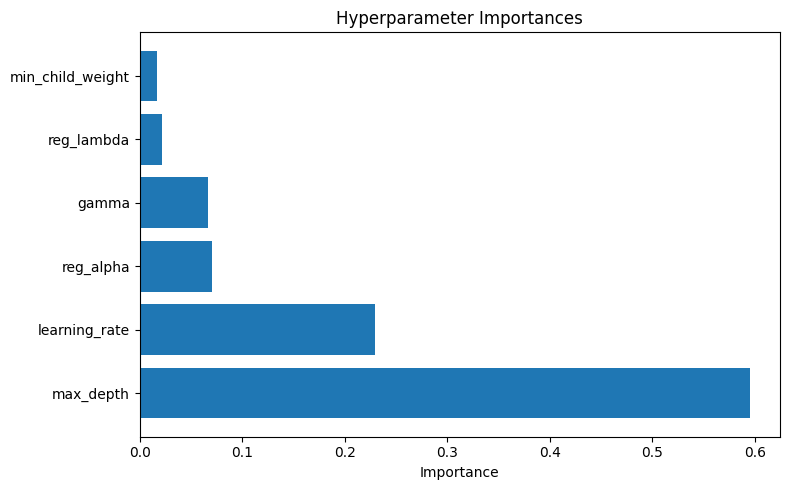

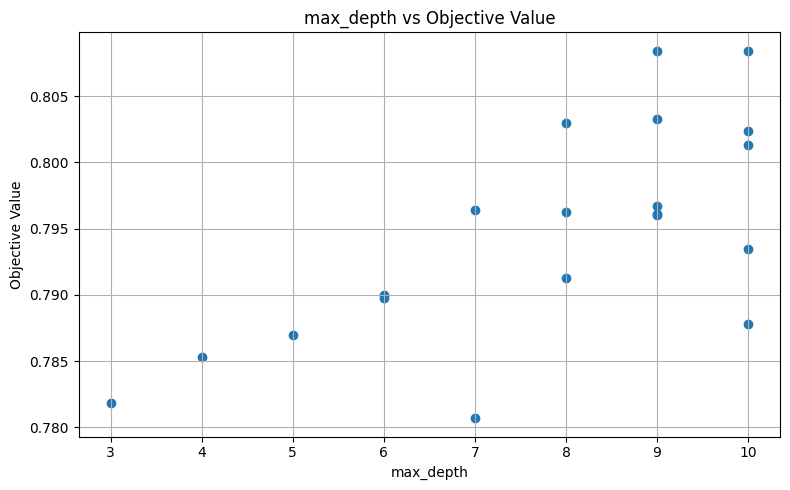

In [252]:
plot_optimization_history_matplotlib(study)
plot_param_importances_matplotlib(study)
plot_param_vs_objective(study, 'max_depth')

XGB Classifier Evaluation

Accuracy: 0.8124
Precision: 0.2572
Recall: 0.3305
ROC AUC: 0.6029

------------------------------
Classification Report:
,               precision    recall  f1-score   support

           0       0.91      0.88      0.89     45170
           1       0.26      0.33      0.29      5900

    accuracy                           0.81     51070
   macro avg       0.58      0.60      0.59     51070
weighted avg       0.83      0.81      0.82     51070



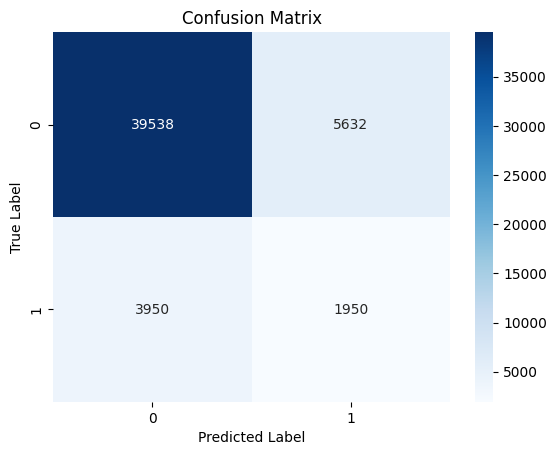

In [253]:
# Evaluate model performance XGB

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred)
xgb_cm = confusion_matrix(y_test, xgb_y_pred)


print("XGB Classifier Evaluation\n")

print("Accuracy:", round(xgb_accuracy, 4))
print("Precision:", round(xgb_precision, 4))
print("Recall:", round(xgb_recall, 4))
print("ROC AUC:", round(xgb_roc_auc, 4))
print(f'\n{"-"*30}\nClassification Report:\n, {classification_report(y_test, xgb_y_pred)}')

# Confusion matrix heatmap
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Models comparisson

In [254]:
# Add all model metrics here
model_comparison = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest",'KNN', 'Logistic Regression',"XGBoost"],
    "Accuracy": [dt_accuracy, rf_accuracy, knn_accuracy, log_accuracy , xgb_accuracy],
    "Precision": [dt_precision, rf_precision, knn_precision, log_precision, xgb_precision],
    "Recall": [dt_recall, rf_recall, knn_recall, log_recall, xgb_recall],
    "ROC AUC": [dt_roc_auc, rf_roc_auc, knn_roc_auc, log_roc_auc, xgb_roc_auc]
})

# Round the values for better display
model_comparison = model_comparison.round(4)

# Show table
#model_comparison['Max'] = np.max()

In [255]:

# Set 'Model' as index to make it easier
df_indexed = model_comparison.set_index("Model")

# Find which model had the max score for each metric
max_models = df_indexed.idxmax()

# Create a new row with the results
df_indexed.loc['Best Model per Metric'] = max_models

# Reset index if you want
df_result = df_indexed.reset_index()
df_result


,Model,Accuracy,Precision,Recall,ROC AUC
0,Decision Tree,0.438,0.1478,0.8108,0.6001
1,Random Forest,0.7735,0.223,0.3864,0.6053
2,KNN,0.6532,0.1346,0.3688,0.5296
3,Logistic Regression,0.6695,0.2014,0.6278,0.6513
4,XGBoost,0.8124,0.2572,0.3305,0.6029
5,Best Model per Metric,XGBoost,XGBoost,Decision Tree,Logistic Regression


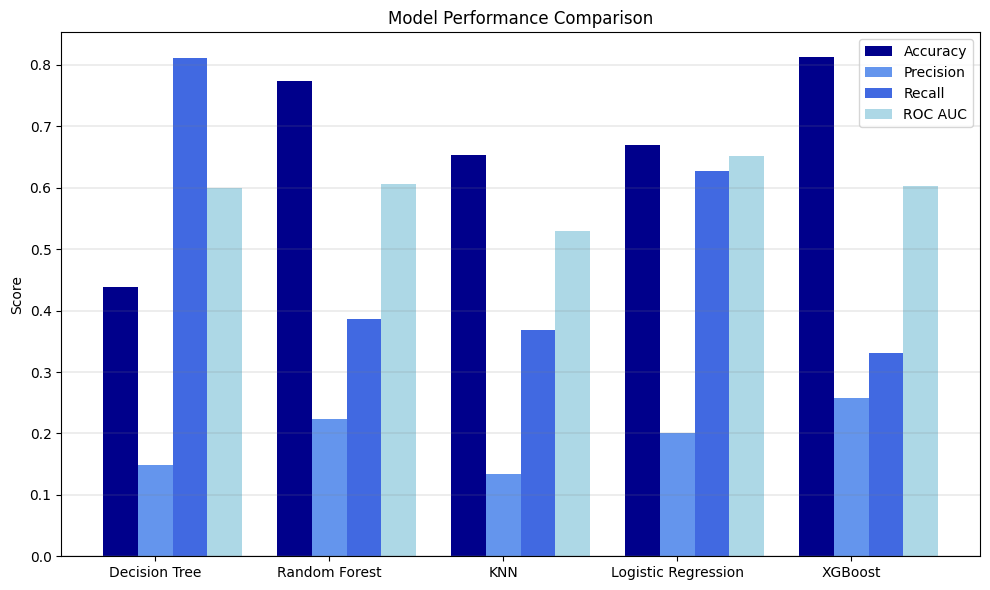

In [256]:

metrics = ['Accuracy', 'Precision', 'Recall', 'ROC AUC']
colors = ['darkblue', 'cornflowerblue', 'royalblue', 'lightblue']
model_names = model_comparison['Model']

bar_width = 0.2
x = range(len(model_names))

# Plot each metric
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar([p + bar_width*i for p in x], model_comparison[metric], width=bar_width, label=metric, color=colors[i])

# Add labels and legend
plt.xticks([p + bar_width for p in x], model_names)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(True, axis ='y', color='grey', linestyle='-', linewidth=0.2)
plt.tight_layout()
plt.show()


In [257]:
# ROC AUC:

# It measures pure discrimination ability: can the model tell defaults from non-defaults?
# It's especially useful when you care about both:
# Catching defaults (high recall),
# Avoiding false alarms (precision).

In [282]:
classifiers = {
    'Decision Tree': dt_best_model, 
    'Random Forest': rf_best_model,
    'Logistic Regression': log_clf,
    'k-NN': knn_best_model,
    'XGBoost': xgb_best_model
}

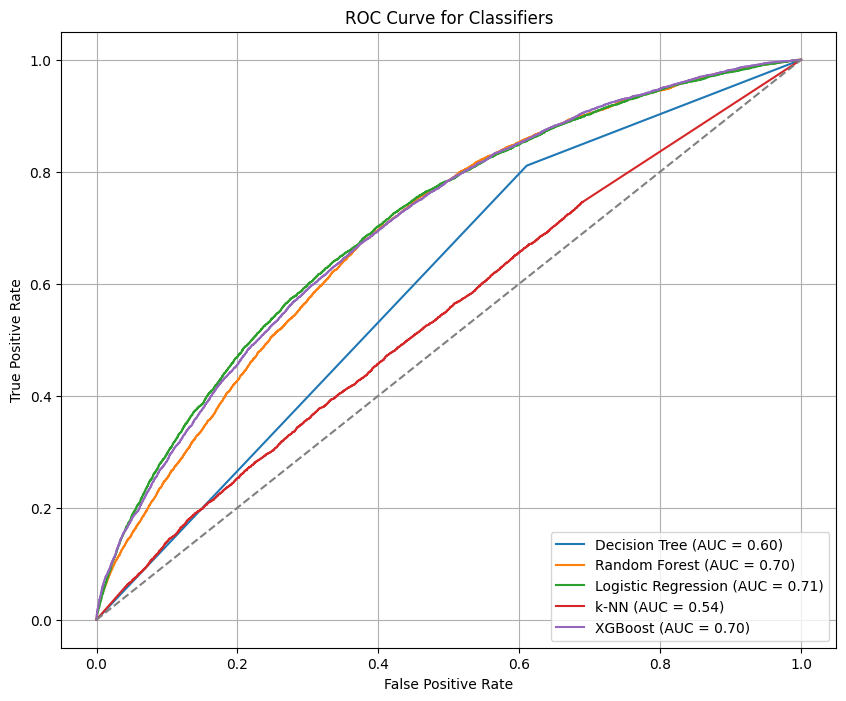

In [283]:


# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its ROC curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test_subset)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve for each classifier
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

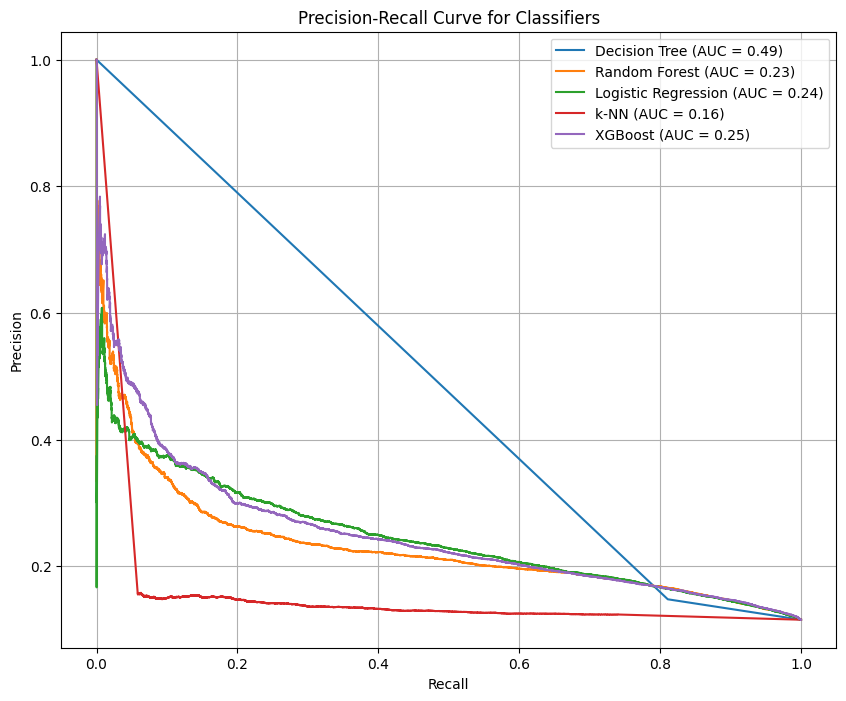

In [284]:
plt.figure(figsize=(10, 8))
# Iterate through each classifier and plot its PR curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test_subset)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    # Calculate PR AUC score
    pr_auc = auc(recall, precision)
    
    # Plot PR curve for each classifier
    plt.plot(recall, precision, label=f'{clf_name} (AUC = {pr_auc:.2f})')

# Add labels and title to the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Classifiers')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()